In [77]:
# base tool
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows',100)
import numpy as np
from sklearn.model_selection import train_test_split
import copy

import warnings
warnings.filterwarnings('ignore')

#visualization
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('default')

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import seaborn as sns    

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
pio.templates.default = "plotly_white"

# 
import datetime



import scipy as sp
# test
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scaling
from sklearn.preprocessing import StandardScaler

# modeling
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# evaluation
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

from collections import Counter

In [2]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        st = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    st.columns = cols
    print('___________________________\nData Types:')
    print(st.Types.value_counts())
    print('___________________________')
    return st

In [3]:
raw_data = pd.read_csv('./Tetuan City power consumption.csv')
raw_data= pd.DataFrame(raw_data)

In [4]:
summary(raw_data)

Data shape: (52416, 9)
___________________________
Data Types:
float64    8
object     1
Name: Types, dtype: int64
___________________________


Types  Counts  Uniques  Nulls            Min  \
DateTime                    object   52416    52416      0  1/1/2017 0:00   
Humidity                   float64   52416     4443      0          11.34   
Temperature                float64   52416     3437      0          3.247   
Wind Speed                 float64   52416      548      0           0.05   
Zone 1 Power Consumption   float64   52416    27709      0        13895.7   
Zone 2  Power Consumption  float64   52416    29621      0        8560.08   
Zone 3  Power Consumption  float64   52416    22838      0        5935.17   
diffuse flows              float64   52416    10449      0          0.011   
general diffuse flows      float64   52416    10504      0          0.004   

                                     Max  
DateTime                   9/9/2017 9:50  
Humidity                            94.8  
Temperature                        40.01  
Wind Speed                         6.483  
Zone 1 Power Consumption         52204.4  
Zone 2  Power Consumption        37408.9  
Zone 3  Power Consumption        47598.3  
diffuse flows                        936  
general diffuse flows               1163

In [5]:
heat_temp = raw_data.iloc[:,-3:]
r_column = list(heat_temp.columns)
heat_temp.rename(columns={r_column[0]:'Zone1',r_column[1]:'Zone2',r_column[2]:'Zone3'},inplace=True)

<AxesSubplot:>

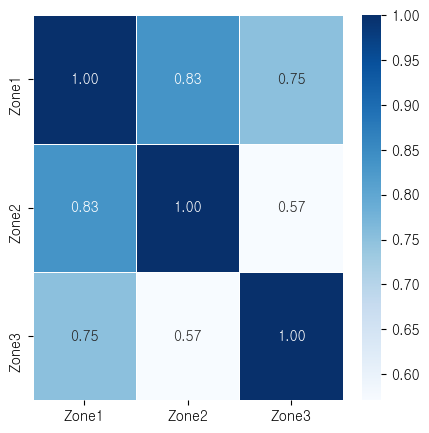

In [6]:
plt.figure(figsize=(5,5))
sns.heatmap(data = heat_temp.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [7]:
def getWeekDay(ts):
    days = ['MON','TUE','WED','THU','FRI','SAT','SUN']
    return days[ts.weekday()]

def getMonth(ts):
    months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    return months[ts.month-1]


In [8]:
def vif(df:pd.DataFrame)->None:
    print('vif score')
    df = df.iloc[:,:-1]
    vif_scores = pd.DataFrame() 

    vif_scores["Attribute"] = df.columns 
    # calculating VIF for each feature 
    vif_scores["VIF Scores"] = [round(variance_inflation_factor(df.values, i) ,2)for i in range(len(df.columns))] 
    display(vif_scores)
    print('-'*50)
    return vif_scores

In [9]:
def acf(data, k):
    data  = np.array(data).reshape(-1)
    mean = data.mean()

    numerator = np.sum((data[:len(data)-k] - mean) * (data[k:] - mean))
    denominator = np.sum(np.square(data - mean))

    acf_val = numerator / denominator

    return acf_val



In [10]:
def pacf(data, k):
    if k == 0:
        pacf_val = 1
    else:
        gamma_array = np.array([acf(data, k) for k in range(1, k + 1)])

        gamma_matrix = []
        for i in range(k):
            temp = [0] * k
            temp[i:] = [acf(data, j) for j in range(k - i)]     # making diagonal
            gamma_matrix.append(temp)

        gamma_matrix = np.array(gamma_matrix)
        gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())     # making symmetric matrix
        pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]
    return pacf_val


In [85]:
def explained_variance_ratio_plot(explained_variance_ratio):
    x_axis = range(1, len(explained_variance_ratio)+1)
    plt.bar(x_axis, explained_variance_ratio,
            align = 'center', label = 'Individual Explained Variance Ratio')
    plt.step(x_axis, np.cumsum(explained_variance_ratio),
             where = 'mid', color='red', label='Cumulative Explained Variance Ratio')
    plt.ylim(0, 1.1)
    plt.xticks(x_axis)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.grid()
    plt.show()

In [11]:
raw_data

DateTime  Temperature  Humidity  Wind Speed  \
0         1/1/2017 0:00        6.559      73.8       0.083   
1         1/1/2017 0:10        6.414      74.5       0.083   
2         1/1/2017 0:20        6.313      74.5       0.080   
3         1/1/2017 0:30        6.121      75.0       0.083   
4         1/1/2017 0:40        5.921      75.7       0.081   
...                 ...          ...       ...         ...   
52411  12/30/2017 23:10        7.010      72.4       0.080   
52412  12/30/2017 23:20        6.947      72.6       0.082   
52413  12/30/2017 23:30        6.900      72.8       0.086   
52414  12/30/2017 23:40        6.758      73.0       0.080   
52415  12/30/2017 23:50        6.580      74.1       0.081   

       general diffuse flows  diffuse flows  Zone 1 Power Consumption  \
0                      0.051          0.119               34055.69620   
1                      0.070          0.085               29814.68354   
2                      0.062          0.100               29128.10127   
3                      0.091          0.096               28228.86076   
4                      0.048          0.085               27335.69620   
...                      ...            ...                       ...   
52411                  0.040          0.096               31160.45627   
52412                  0.051          0.093               30430.41825   
52413                  0.084          0.074               29590.87452   
52414                  0.066          0.089               28958.17490   
52415                  0.062          0.111               28349.80989   

       Zone 2  Power Consumption  Zone 3  Power Consumption  
0                    16128.87538                20240.96386  
1                    19375.07599                20131.08434  
2                    19006.68693                19668.43373  
3                    18361.09422                18899.27711  
4                    17872.34043                18442.40964  
...                          ...                        ...  
52411                26857.31820                14780.31212  
52412                26124.57809                14428.81152  
52413                25277.69254                13806.48259  
52414                24692.23688                13512.60504  
52415                24055.23167                13345.49820  

[52416 rows x 9 columns]

# 시게열적 특성

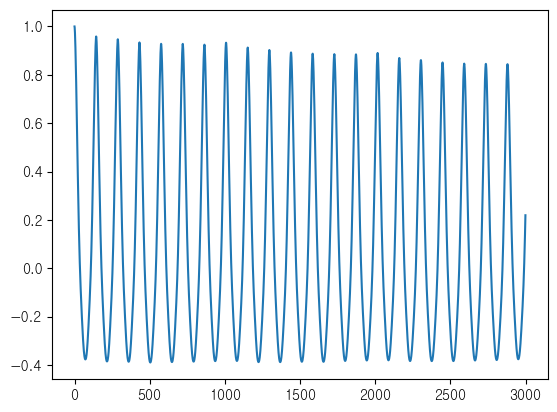

In [12]:
t = []
x = range(3000)
for n in x:
    t.append(acf(raw_data['Zone 1 Power Consumption'],n))
plt.plot(x,t)

# 하루 총소모량으로 변환

In [13]:
raw_data['date']=raw_data['DateTime'].map(lambda x: x.split()[0])
col = ['date','weekDay','month','maxTemp','minTemp','meanTemp','maxHum','minHum','meanHum','maxWind','mimWind','meanWind','maxGenDiff','minGenDiff','meanGenDiff','manDiff','minDiff','meanDiff','powerConsumption']
df = pd.DataFrame(columns=col)
uni_date= set(raw_data['date'])
for day in uni_date:
    dateStamp = datetime.datetime.strptime(day,'%m/%d/%Y')
    tmp = raw_data[raw_data['date']==day]
    date=day
    weekDay = getWeekDay(dateStamp)
    month = getMonth(dateStamp)
    maxTemp=tmp['Temperature'].max()
    minTemp=tmp['Temperature'].min()
    meanTemp=tmp['Temperature'].mean()
    maxHum=tmp['Humidity'].max()
    minHum=tmp['Humidity'].min()
    meanHum=tmp['Humidity'].mean()
    maxWind=tmp['Wind Speed'].max()
    mimWind=tmp['Wind Speed'].min()
    meanWind=tmp['Wind Speed'].mean()
    maxGenDiff=tmp['general diffuse flows'].max()
    minGenDiff=tmp['general diffuse flows'].min()
    meanGenDiff=tmp['general diffuse flows'].mean()
    manDiff=tmp['diffuse flows'].max()
    minDiff=tmp['diffuse flows'].min()
    meanDiff=tmp['diffuse flows'].mean()
    powerConsumption=round(tmp['Zone 1 Power Consumption'].sum()/1000000,3)
    dt = [date,weekDay,month,maxTemp,minTemp,meanTemp,maxHum,minHum,meanHum,maxWind,mimWind,meanWind,maxGenDiff,minGenDiff,meanGenDiff,manDiff,minDiff,meanDiff,powerConsumption]
    dt_insert = {}
    for idx,c in enumerate(col):
        dt_insert[c]=dt[idx]


    df = df.append(dt_insert,ignore_index=True)

In [14]:
df = df.drop(columns=['weekDay','month'])

In [15]:
df

date  maxTemp  minTemp   meanTemp  maxHum  minHum    meanHum  \
0    3/19/2017    14.59     9.74  11.993889   90.80   54.46  77.239653   
1    8/10/2017    35.89    25.29  29.543889   66.56   22.94  45.437431   
2    1/12/2017    17.61     9.06  13.895556   83.90   64.47  75.764167   
3    7/19/2017    35.22    21.40  28.355139   59.65   24.15  43.078958   
4    9/30/2017    24.07    15.65  20.025972   87.70   62.99  76.919583   
..         ...      ...      ...        ...     ...     ...        ...   
359   2/1/2017    14.03     8.52  11.241597   68.12   34.92  56.077708   
360   1/6/2017    15.78     7.88  11.685208   88.90   61.97  77.257778   
361   2/6/2017    13.17     7.31  10.513958   64.84   37.96  50.349375   
362  5/22/2017    21.38    17.17  18.863750   83.00   58.36  73.565764   
363  4/28/2017    23.70    12.61  18.224514   80.20   38.94  57.488403   

     maxWind  mimWind  meanWind  maxGenDiff  minGenDiff  meanGenDiff  manDiff  \
0      0.089    0.069  0.080653       199.2       0.033    40.675160    181.9   
1      4.912    4.900  4.904389       896.0       0.062   219.786264    356.7   
2      0.092    0.066  0.076806       709.0       0.022   101.717854    375.7   
3      4.936    4.907  4.914486       888.0       0.051   312.691653    395.1   
4      4.929    4.914  4.920556       717.0       0.048   205.340771    167.9   
..       ...      ...       ...         ...         ...          ...      ...   
359    4.926    4.913  4.919806       626.3       0.029   163.062771    668.4   
360    4.708    0.080  0.145951       349.9       0.022    63.700451    308.3   
361    0.094    0.081  0.086111       702.0       0.029   124.597368    268.8   
362    0.075    0.064  0.069806      1034.0       0.033   231.688583    599.5   
363    4.478    0.075  0.134153       902.0       0.022   288.959278    479.1   

     minDiff    meanDiff  powerConsumption  
0      0.082   37.473132             4.296  
1      0.033   89.199465             5.312  
2      0.078   70.149000             4.619  
3      0.063   59.108257             5.450  
4      0.052   31.490861             4.532  
..       ...         ...               ...  
359    0.078  177.604514             4.518  
360    0.070   59.333563             4.423  
361    0.059   61.267889             4.398  
362    0.052  110.316118             4.794  
363    0.070   85.439403             4.543  

[364 rows x 17 columns]

In [19]:
summary(df)

Data shape: (364, 17)
___________________________
Data Types:
float64    16
object      1
Name: Types, dtype: int64
___________________________


Types  Counts  Uniques  Nulls        Min       Max
date               object     364      364      0   1/1/2017  9/9/2017
manDiff           float64     364      353      0       89.7       936
maxGenDiff        float64     364      278      0      105.1      1163
maxHum            float64     364      200      0      50.12      94.8
maxTemp           float64     364      332      0      12.04     40.01
maxWind           float64     364      107      0      0.073     6.483
meanDiff          float64     364      364      0    19.2504   209.134
meanGenDiff       float64     364      364      0    26.4449   335.066
meanHum           float64     364      364      0    29.3599   89.5854
meanTemp          float64     364      364      0    8.62787    32.429
meanWind          float64     364      364      0  0.0644306   4.93049
mimWind           float64     364       60      0       0.05     4.916
minDiff           float64     364       28      0      0.011     0.111
minGenDiff        float64     364       21      0      0.004     0.077
minHum            float64     364      355      0      11.34      86.2
minTemp           float64     364      336      0      3.247     25.58
powerConsumption  float64     364      321      0      3.855     5.578

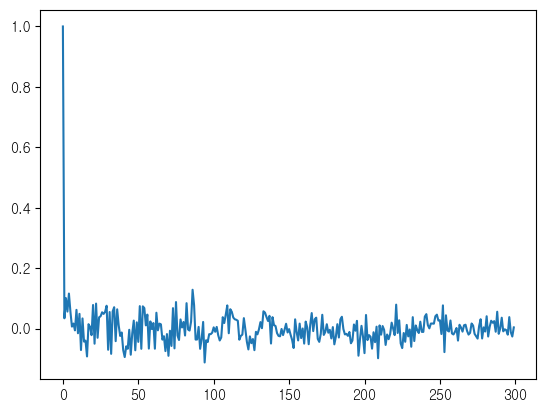

In [20]:
t = []
x = range(300)
for n in x:
    t.append(acf(df['powerConsumption'],n))
plt.plot(x,t)

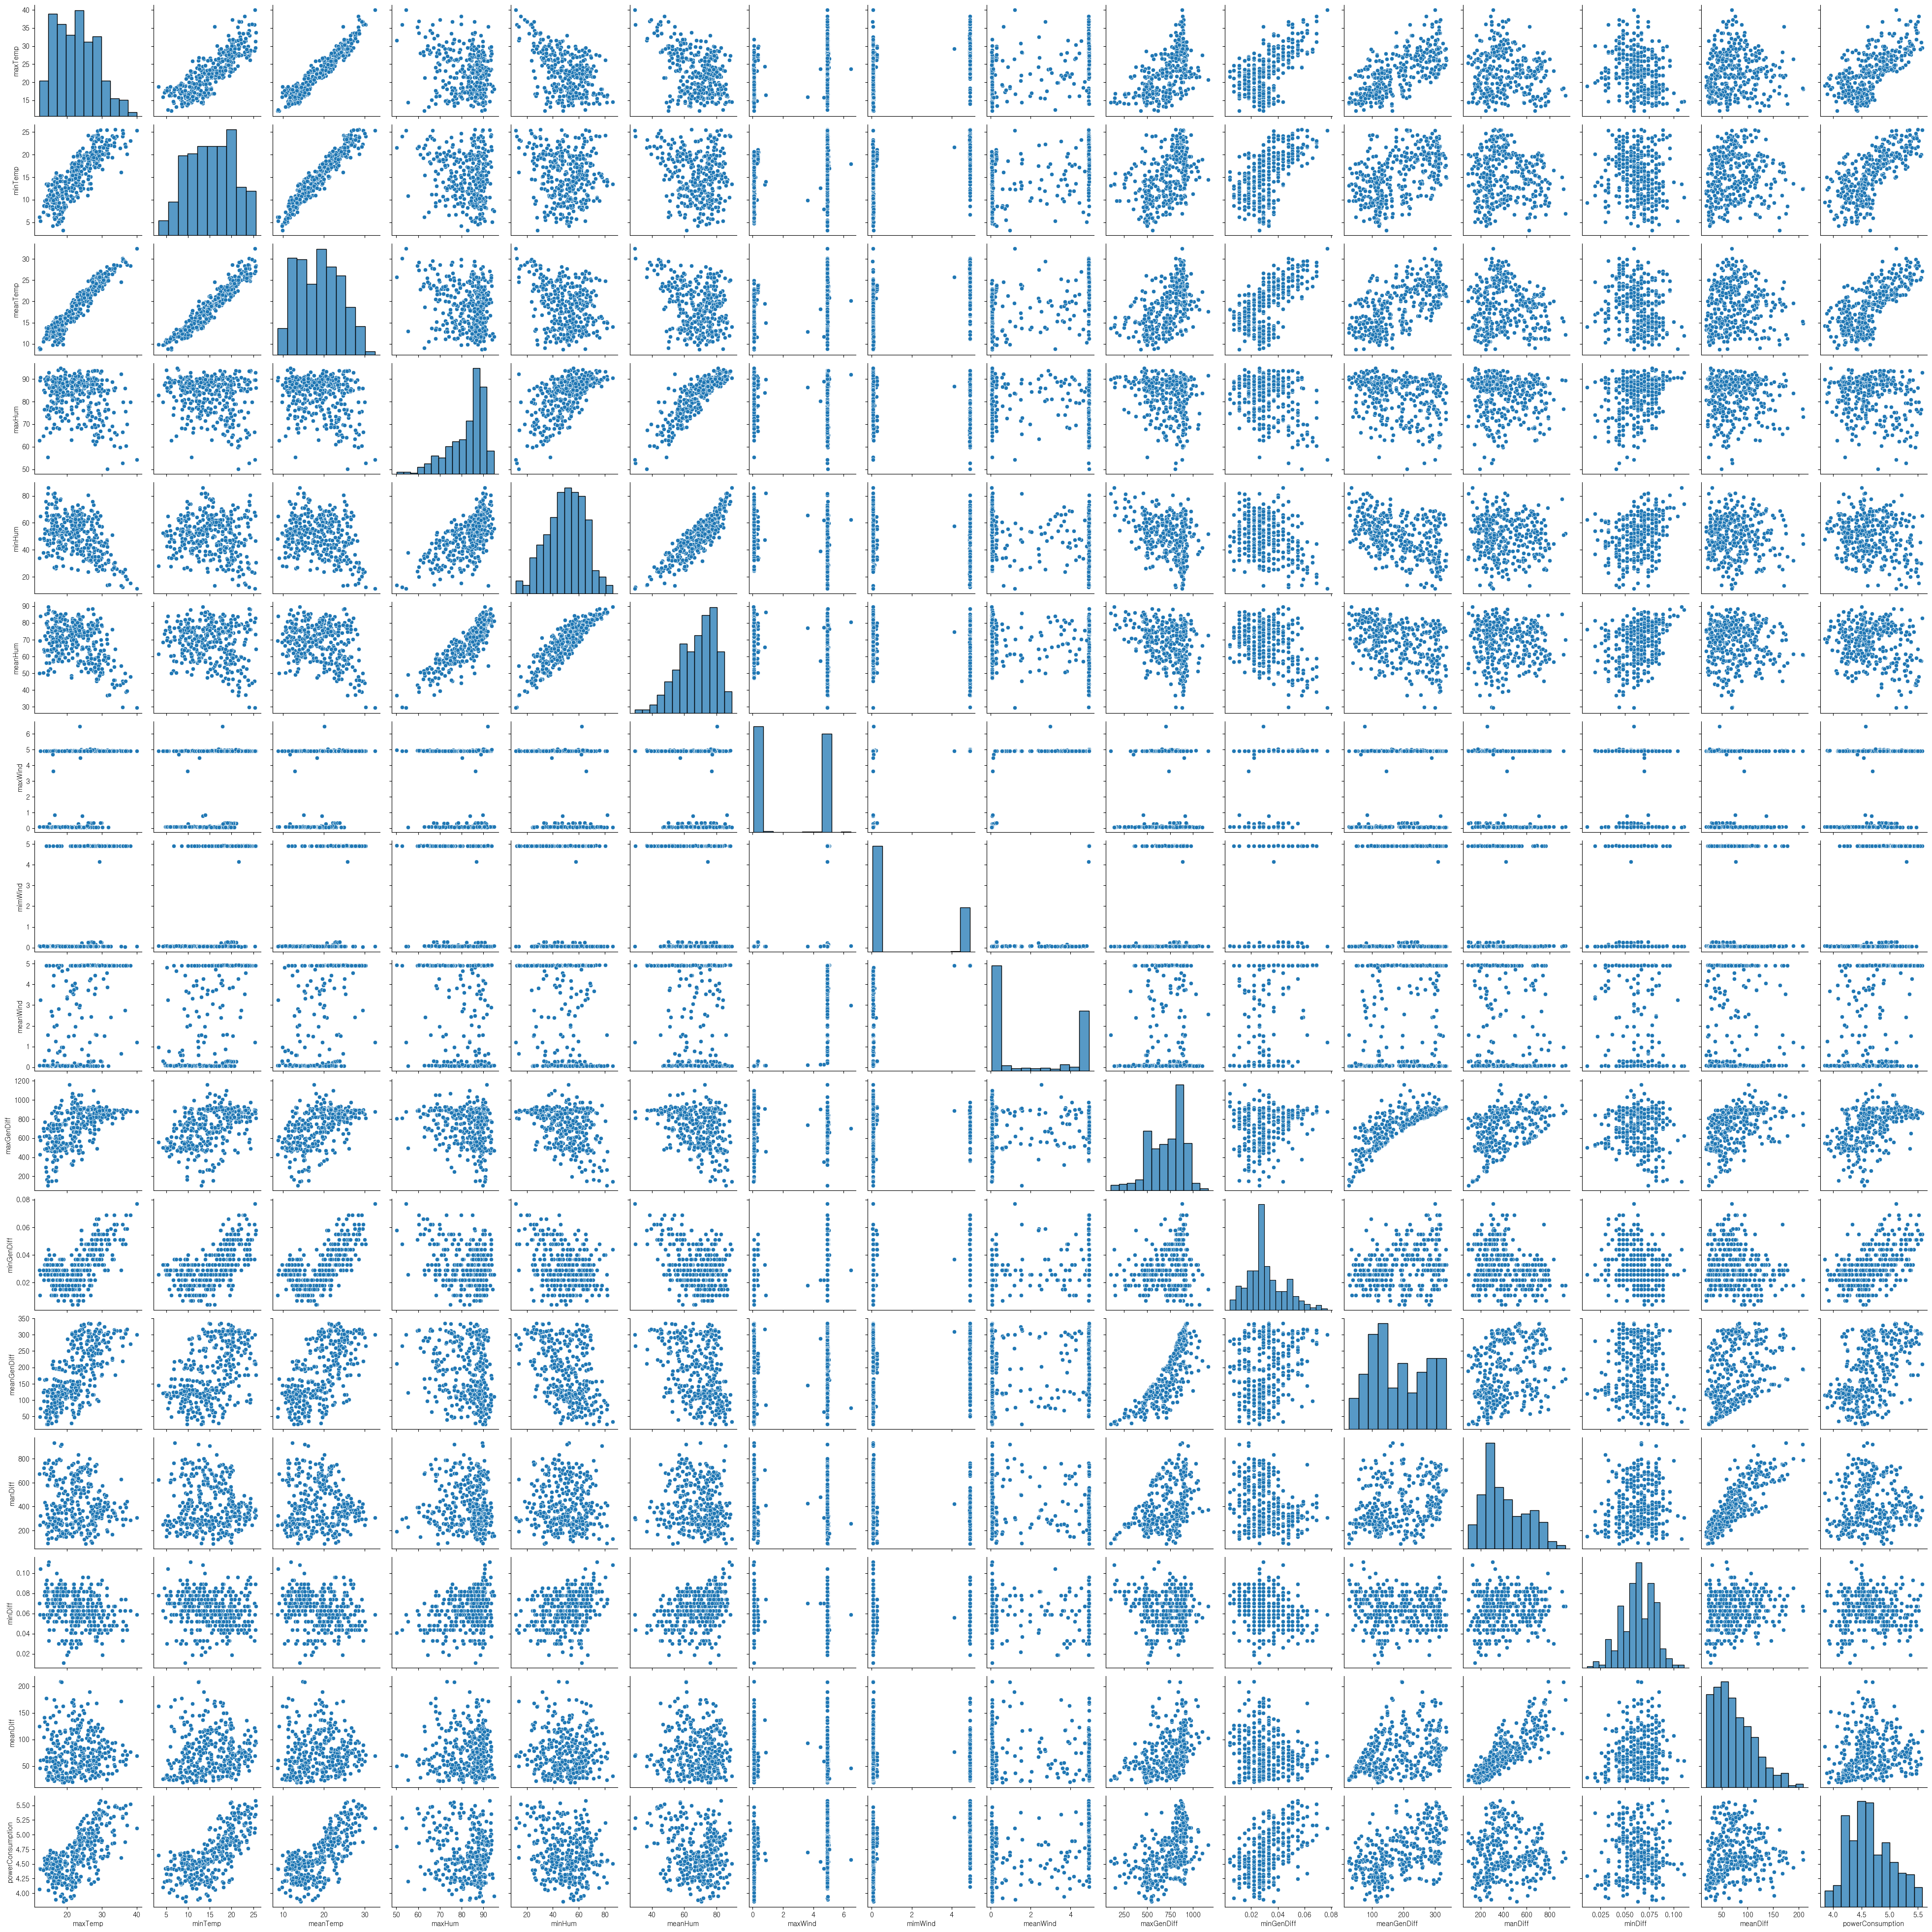

In [21]:
sns.pairplot(df.iloc[:,1:])

In [22]:
vif(df.iloc[:,1:])['VIF Scores'].argmax()

vif score


Attribute  VIF Scores
0       maxTemp      872.75
1       minTemp      434.90
2      meanTemp     2178.60
3        maxHum      560.19
4        minHum      162.14
5       meanHum      814.74
6       maxWind       11.49
7       mimWind        7.99
8      meanWind       23.23
9    maxGenDiff       50.57
10   minGenDiff       11.89
11  meanGenDiff       24.57
12      manDiff       24.35
13      minDiff       19.29
14     meanDiff       17.74

--------------------------------------------------


2

In [23]:
tmp = df.drop(columns=['meanTemp','meanHum','maxTemp','maxHum','maxGenDiff','meanWind','manDiff','minTemp','minDiff'])
vif(tmp.iloc[:,1:])['VIF Scores']
#선형성이 가장 높은 temperature 데이터가 모두 제거되었다. -> PCA loading  

vif score


Attribute  VIF Scores
0       minHum        5.01
1      maxWind        3.82
2      mimWind        2.95
3   minGenDiff        6.88
4  meanGenDiff        7.80
5     meanDiff        5.82

--------------------------------------------------


0    5.01
1    3.82
2    2.95
3    6.88
4    7.80
5    5.82
Name: VIF Scores, dtype: float64

In [64]:
df

date  maxTemp  minTemp   meanTemp  maxHum  minHum    meanHum  \
0    3/19/2017    14.59     9.74  11.993889   90.80   54.46  77.239653   
1    8/10/2017    35.89    25.29  29.543889   66.56   22.94  45.437431   
2    1/12/2017    17.61     9.06  13.895556   83.90   64.47  75.764167   
3    7/19/2017    35.22    21.40  28.355139   59.65   24.15  43.078958   
4    9/30/2017    24.07    15.65  20.025972   87.70   62.99  76.919583   
..         ...      ...      ...        ...     ...     ...        ...   
359   2/1/2017    14.03     8.52  11.241597   68.12   34.92  56.077708   
360   1/6/2017    15.78     7.88  11.685208   88.90   61.97  77.257778   
361   2/6/2017    13.17     7.31  10.513958   64.84   37.96  50.349375   
362  5/22/2017    21.38    17.17  18.863750   83.00   58.36  73.565764   
363  4/28/2017    23.70    12.61  18.224514   80.20   38.94  57.488403   

     maxWind  mimWind  meanWind  maxGenDiff  minGenDiff  meanGenDiff  manDiff  \
0      0.089    0.069  0.080653       199.2       0.033    40.675160    181.9   
1      4.912    4.900  4.904389       896.0       0.062   219.786264    356.7   
2      0.092    0.066  0.076806       709.0       0.022   101.717854    375.7   
3      4.936    4.907  4.914486       888.0       0.051   312.691653    395.1   
4      4.929    4.914  4.920556       717.0       0.048   205.340771    167.9   
..       ...      ...       ...         ...         ...          ...      ...   
359    4.926    4.913  4.919806       626.3       0.029   163.062771    668.4   
360    4.708    0.080  0.145951       349.9       0.022    63.700451    308.3   
361    0.094    0.081  0.086111       702.0       0.029   124.597368    268.8   
362    0.075    0.064  0.069806      1034.0       0.033   231.688583    599.5   
363    4.478    0.075  0.134153       902.0       0.022   288.959278    479.1   

     minDiff    meanDiff  powerConsumption  
0      0.082   37.473132             4.296  
1      0.033   89.199465             5.312  
2      0.078   70.149000             4.619  
3      0.063   59.108257             5.450  
4      0.052   31.490861             4.532  
..       ...         ...               ...  
359    0.078  177.604514             4.518  
360    0.070   59.333563             4.423  
361    0.059   61.267889             4.398  
362    0.052  110.316118             4.794  
363    0.070   85.439403             4.543  

[364 rows x 17 columns]

In [87]:
# 표준화
ss = StandardScaler()
X_s = pd.DataFrame(ss.fit_transform(df.iloc[:,1:-1]),columns=[df.iloc[:,1:-1].columns])
y = df.iloc[:,-1]

In [89]:
X_s

maxTemp   minTemp  meanTemp    maxHum    minHum   meanHum   maxWind  \
0   -1.406770 -1.060356 -1.312251  0.975828  0.306577  0.781529 -0.977941   
1    2.274633  1.931256  2.066498 -1.869651 -1.877643 -1.986174  1.025593   
2   -0.884805 -1.191179 -0.946140  0.165852  1.000233  0.653119 -0.976695   
3    2.158833  1.182872  1.837638 -2.680801 -1.793794 -2.191429  1.035562   
4    0.231714  0.076649  0.234096  0.611926  0.897675  0.753673  1.032655   
..        ...       ...       ...       ...       ...       ...       ...   
359 -1.503558 -1.295068 -1.457083 -1.686526 -1.047473 -1.060166  1.031408   
360 -1.201095 -1.418196 -1.371679  0.752791  0.826992  0.783106  0.940848   
361 -1.652197 -1.527856 -1.597169 -2.071558 -0.836812 -1.558695 -0.975864   
362 -0.233214  0.369076  0.010343  0.060203  0.576833  0.461795 -0.983757   
363  0.167765 -0.508207 -0.112723 -0.268483 -0.768902 -0.937395  0.845304   

      mimWind  meanWind maxGenDiff minGenDiff meanGenDiff   manDiff   minDiff  \
0   -0.653955 -0.853733  -2.664767   0.144715   -1.650570 -1.214998  1.106906   
1    1.538567  1.338147   0.938323   2.223106    0.431055 -0.275596 -1.841978   
2   -0.655316 -0.855481  -0.028637  -0.643639   -0.941133 -0.173488  0.866181   
3    1.541744  1.342735   0.896955   1.434751    1.510799 -0.069229 -0.036539   
4    1.544921  1.345493   0.012730   1.219745    0.263170 -1.290236 -0.698533   
..        ...       ...        ...        ...         ...       ...       ...   
359  1.544467  1.345152  -0.456272  -0.141959   -0.228184  1.399526  0.866181   
360 -0.648962 -0.824062  -1.885511  -0.643639   -1.382971 -0.535705  0.384730   
361 -0.648509 -0.851253  -0.064834  -0.141959   -0.675228 -0.747984 -0.277264   
362 -0.656224 -0.858662   1.651908   0.144715    0.569384  1.029247 -0.698533   
363 -0.651232 -0.829423   0.969348  -0.643639    1.234982  0.382200  0.384730   

     meanDiff  
0   -0.972189  
1    0.366858  
2   -0.126304  
3   -0.412117  
4   -1.127053  
..        ...  
359  2.655413  
360 -0.406285  
361 -0.356211  
362  0.913508  
363  0.269521  

[364 rows x 15 columns]

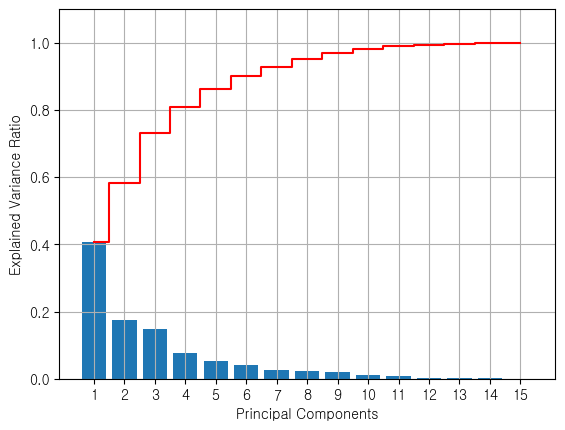

In [90]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 


pca = PCA(n_components=X_s.shape[1])
pca.fit(X_s)
explained_variance_ratio = pca.explained_variance_ratio_

   
explained_variance_ratio_plot(explained_variance_ratio)

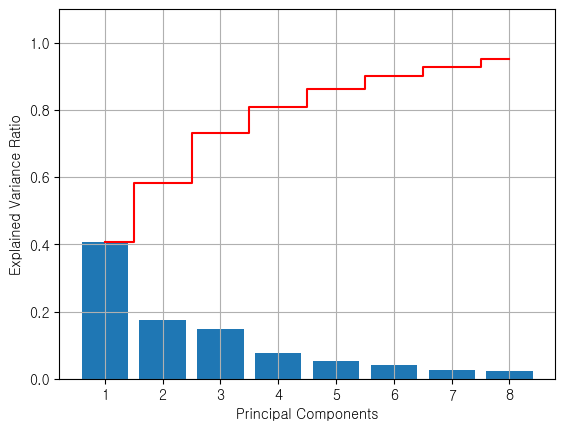

In [93]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_s)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_plot(explained_variance_ratio)
X_reduced = pd.DataFrame(X_reduced,columns=['component1','component2','component3','component4','component5','component6','component7','component8'])


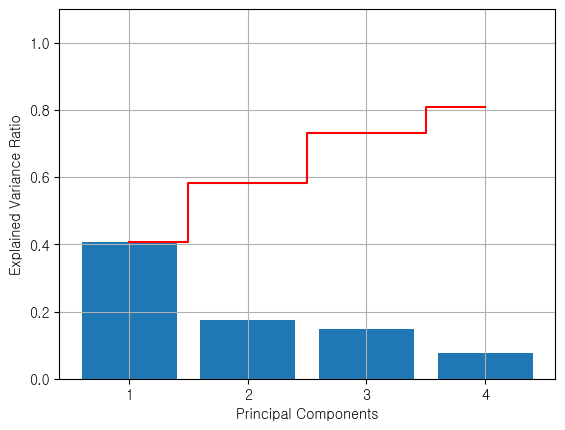

In [94]:
pca = PCA(n_components=0.80)
X_reduced = pca.fit_transform(X_s)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_plot(explained_variance_ratio)
X_reduced = pd.DataFrame(X_reduced,columns=['component1','component2','component3','component4'])


In [95]:
lr =LinearRegression()
lr.fit(X=X_reduced,y=y)
lr.score(X_reduced,y)

0.5772027103162904

In [96]:
rd =Ridge(alpha=0.4)
rd.fit(X=X_reduced,y=y)
rd.score(X_reduced,y)

0.5772026482959565

In [97]:
rf =RandomForestRegressor()
rf.fit(X=X_reduced,y=y)
rf.score(X_reduced,y)

0.9479225129848503

In [29]:
pca = PCA(n_components=1)
pca.fit(X_s)
newIndex = pca.fit_transform(X_s)
print(newIndex)
pc1 = newIndex[:, 0]

# Coefficients
loadings = pd.DataFrame(pca.components_.T, columns = ['PC1'], index = df.iloc[:,1:-1].columns)

result = pd.DataFrame(X_s)
result['SRVR'] = y
result['PC1'] = pc1
# print(result)
abs(result.corr()['PC1'])

[[-3.78905293]
 [ 5.81903712]
 [-2.74788689]
 [ 5.43427008]
 [ 1.26999858]
 [-3.30562069]
 [-0.60669721]
 [-0.39499859]
 [ 1.95157308]
 [ 0.38838744]
 [ 3.37940295]
 [-0.43385633]
 [-2.38386669]
 [-2.42373828]
 [ 4.05667956]
 [ 0.53066631]
 [ 1.52851086]
 [-3.01670524]
 [ 0.37046704]
 [-0.30198467]
 [ 0.79447816]
 [ 2.66509702]
 [ 2.72605023]
 [ 4.15817171]
 [-0.12123948]
 [-2.13208976]
 [ 5.04496171]
 [-3.21958613]
 [-3.45742643]
 [-0.07882686]
 [-1.95411865]
 [ 1.58793749]
 [ 0.13020814]
 [-4.01376778]
 [-1.39176232]
 [-2.07991953]
 [ 2.49131848]
 [-0.24680282]
 [-0.46048288]
 [-2.27104043]
 [ 0.87502645]
 [-2.34179657]
 [-2.01900098]
 [ 4.11817835]
 [-0.80801771]
 [ 4.2509649 ]
 [ 0.67888187]
 [ 3.72131887]
 [-2.0807303 ]
 [ 0.61909837]
 [-0.91495513]
 [-1.13406129]
 [ 0.84029139]
 [-3.38006864]
 [ 1.17927621]
 [-0.2279266 ]
 [-0.13684027]
 [-0.60579922]
 [-0.36841199]
 [ 6.22473904]
 [-1.30163198]
 [ 1.21096613]
 [ 1.76078786]
 [ 2.38826971]
 [-3.86767488]
 [ 4.05954024]
 [ 3.59191

0       0.909397
1       0.785616
2       0.888168
3       0.460962
4       0.573055
5       0.576467
6       0.639766
7       0.696354
8       0.722722
9       0.639693
10      0.714789
11      0.728041
12      0.020294
13      0.351707
14      0.097194
SRVR    0.691243
PC1     1.000000
Name: PC1, dtype: float64

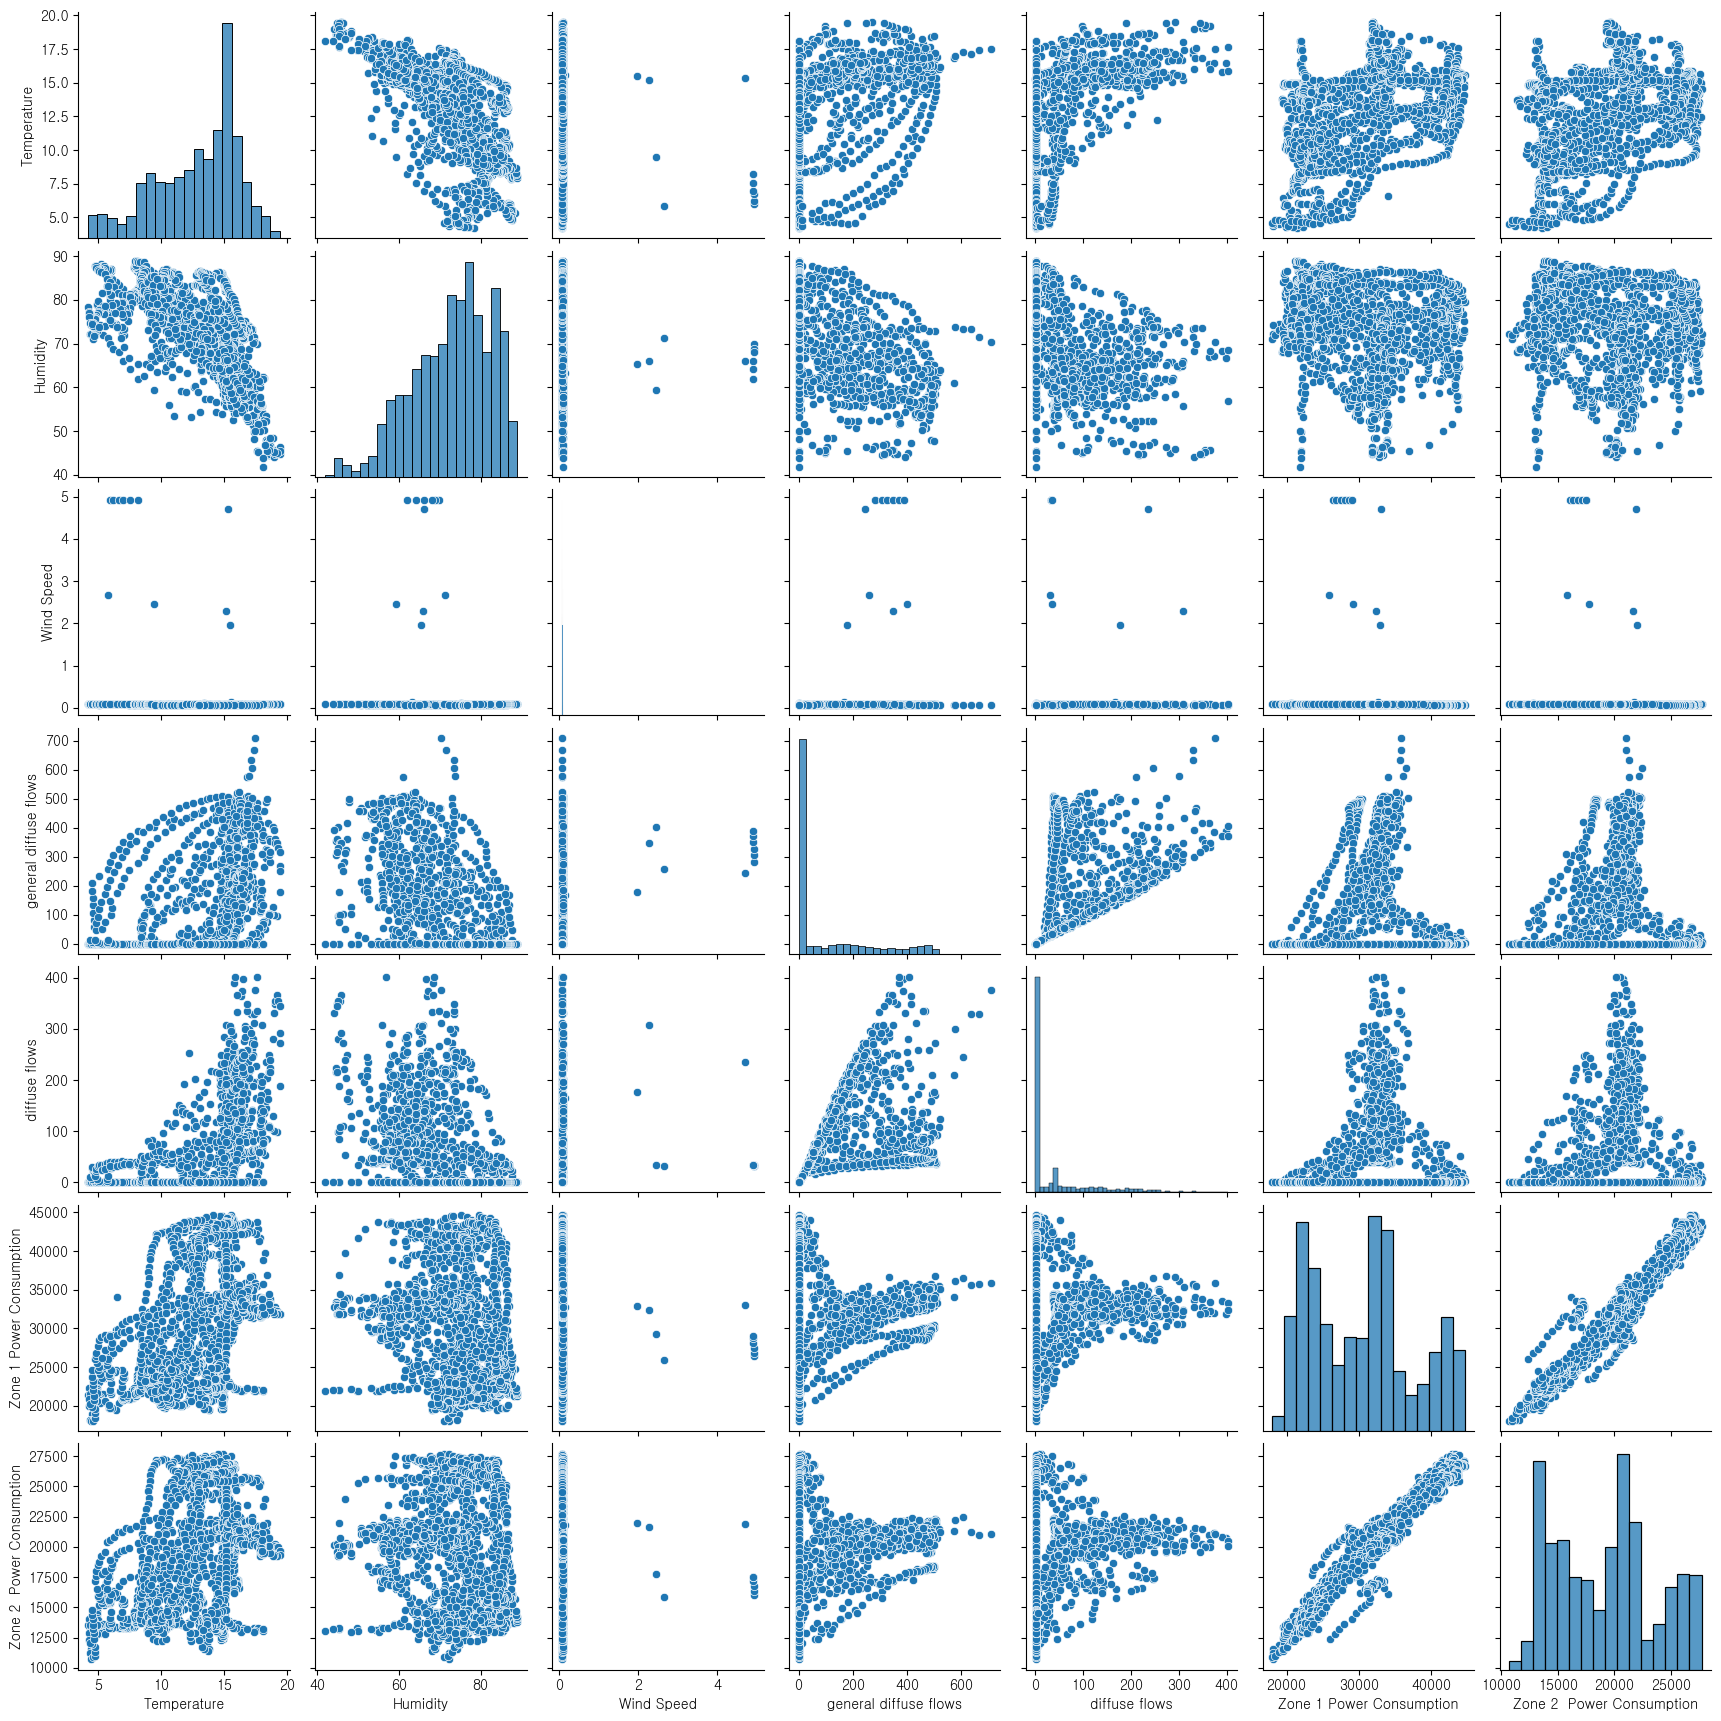

In [30]:
sns.pairplot(raw_data.iloc[:2000,1:-2])

In [31]:
raw_data['general diffuse flows'].value_counts()


0.055      1576
0.062      1557
0.051      1497
0.059      1474
0.066      1459
           ... 
664.200       1
15.390        1
221.300       1
520.900       1
66.240        1
Name: general diffuse flows, Length: 10504, dtype: int64

In [32]:
raw_data['Wind Speed'].value_counts()

0.082    2291
0.083    1979
0.084    1831
0.081    1804
0.085    1513
         ... 
4.519       1
0.672       1
0.178       1
1.324       1
0.212       1
Name: Wind Speed, Length: 548, dtype: int64

In [33]:
vif(raw_data.iloc[:,1:-2])

vif score


Attribute  VIF Scores
0               Temperature       19.72
1                  Humidity        9.47
2                Wind Speed        2.21
3     general diffuse flows        2.85
4             diffuse flows        2.02
5  Zone 1 Power Consumption       20.96

--------------------------------------------------


Attribute  VIF Scores
0               Temperature       19.72
1                  Humidity        9.47
2                Wind Speed        2.21
3     general diffuse flows        2.85
4             diffuse flows        2.02
5  Zone 1 Power Consumption       20.96

In [34]:
# 주기성 확인 auto correlation ACF plot
# 계절 변수
# lag ? PACF확인
# 이상치
# 정규성


In [35]:
raw_data.iloc[:,1:-2].corr()

Temperature  Humidity  Wind Speed  \
Temperature                   1.000000 -0.460243    0.477109   
Humidity                     -0.460243  1.000000   -0.135853   
Wind Speed                    0.477109 -0.135853    1.000000   
general diffuse flows         0.460294 -0.468138    0.133733   
diffuse flows                 0.196522 -0.256886   -0.000972   
Zone 1 Power Consumption      0.440221 -0.287421    0.167444   
Zone 2  Power Consumption     0.382428 -0.294961    0.146413   

                           general diffuse flows  diffuse flows  \
Temperature                             0.460294       0.196522   
Humidity                               -0.468138      -0.256886   
Wind Speed                              0.133733      -0.000972   
general diffuse flows                   1.000000       0.564718   
diffuse flows                           0.564718       1.000000   
Zone 1 Power Consumption                0.187965       0.080274   
Zone 2  Power Consumption               0.157223       0.044667   

                           Zone 1 Power Consumption  Zone 2  Power Consumption  
Temperature                                0.440221                   0.382428  
Humidity                                  -0.287421                  -0.294961  
Wind Speed                                 0.167444                   0.146413  
general diffuse flows                      0.187965                   0.157223  
diffuse flows                              0.080274                   0.044667  
Zone 1 Power Consumption                   1.000000                   0.834519  
Zone 2  Power Consumption                  0.834519                   1.000000

In [36]:
X = raw_data.iloc[:,1:-3]
y = raw_data.iloc[:,-3:]
y1 = raw_data.iloc[:,-3]
y2 = raw_data.iloc[:,-2]
y3 = raw_data.iloc[:,-1]

ConversionError: Failed to convert value(s) to axis units: array(['1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017',
       '1/1/2017', '1/1/2017', '1/1/2017', '1/1/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017', '1/2/2017',
       '1/2/2017', '1/2/2017', '1/2/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017', '1/3/2017',
       '1/3/2017', '1/3/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017', '1/4/2017',
       '1/4/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017', '1/5/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017',
       '1/6/2017', '1/6/2017', '1/6/2017', '1/6/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017',
       '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017', '1/7/2017'],
      dtype=object)

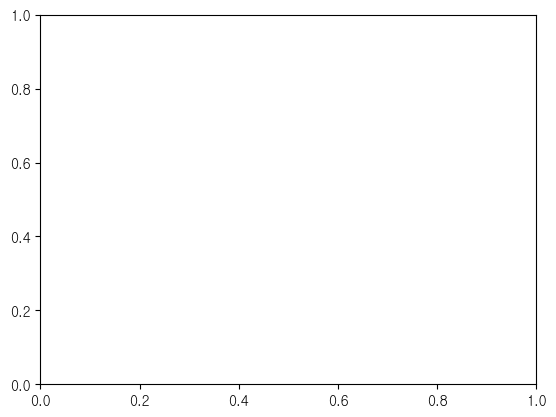

In [37]:
plt.plot(y[:1000])

# Baseline

In [ ]:
X_pre_train = X.iloc[:,:]
y_pre_train = y.iloc[:,0]

In [ ]:
y_pre_train

0        34055.69620
1        29814.68354
2        29128.10127
3        28228.86076
4        27335.69620
            ...     
52411    31160.45627
52412    30430.41825
52413    29590.87452
52414    28958.17490
52415    28349.80989
Name: Zone 1 Power Consumption, Length: 52416, dtype: float64

In [ ]:
ss = StandardScaler()
X_pre_train_s = ss.fit_transform(X_pre_train)
X_pre_train_s = pd.DataFrame(X_pre_train_s,columns=X_pre_train.columns)
X_pre_train_s

Temperature  Humidity  Wind Speed  general diffuse flows  diffuse flows
0        -2.106645  0.356277   -0.798900              -0.690797      -0.603085
1        -2.131578  0.401291   -0.798900              -0.690725      -0.603359
2        -2.148946  0.401291   -0.800178              -0.690755      -0.603238
3        -2.181962  0.433443   -0.798900              -0.690646      -0.603270
4        -2.216353  0.478456   -0.799752              -0.690808      -0.603359
...            ...       ...         ...                    ...            ...
52411    -2.029092  0.266251   -0.800178              -0.690838      -0.603270
52412    -2.039925  0.279112   -0.799326              -0.690797      -0.603294
52413    -2.048007  0.291973   -0.797623              -0.690672      -0.603447
52414    -2.072425  0.304834   -0.800178              -0.690740      -0.603326
52415    -2.103034  0.375569   -0.799752              -0.690755      -0.603149

[52416 rows x 5 columns]

                                    OLS Regression Results                                   
Dep. Variable:     Zone 1 Power Consumption   R-squared (uncentered):                   0.952
Model:                                  OLS   Adj. R-squared (uncentered):              0.952
Method:                       Least Squares   F-statistic:                          2.092e+05
Date:                      Thu, 26 May 2022   Prob (F-statistic):                        0.00
Time:                              18:47:30   Log-Likelihood:                     -5.4018e+05
No. Observations:                     52416   AIC:                                  1.080e+06
Df Residuals:                         52411   BIC:                                  1.080e+06
Df Model:                                 5                                                  
Covariance Type:                  nonrobust                                                  
                            coef    std err          t      

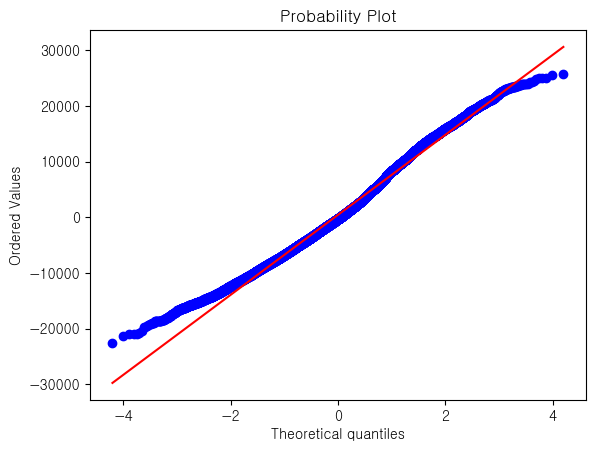

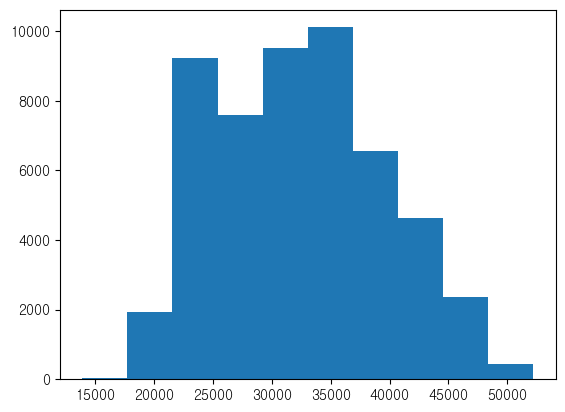

52347288.7575659


In [ ]:
model2 = sm.OLS(y_pre_train,X_pre_train)
result2 = model2.fit()
print(result2.summary())
sp.stats.probplot(result2.resid, plot=plt)

plt.show()
test = sm.stats.omni_normtest(result2.resid)
plt.hist(y1)
plt.show()
# print(r2_score(y_test, result2.predict(X_test)))
print(mean_squared_error(y_pre_train,result2.predict(X_pre_train)))

In [ ]:
result2.predict(X_pre_train)

0        20239.481918
1        20206.730171
2        20098.462604
3        19977.737621
4        19886.229143
             ...     
52411    20480.942624
52412    20447.269811
52413    20430.022201
52414    20314.249669
52415    20316.649723
Length: 52416, dtype: float64

In [ ]:
y_pre_train

0        34055.69620
1        29814.68354
2        29128.10127
3        28228.86076
4        27335.69620
            ...     
52411    31160.45627
52412    30430.41825
52413    29590.87452
52414    28958.17490
52415    28349.80989
Name: Zone 1 Power Consumption, Length: 52416, dtype: float64

<AxesSubplot:>

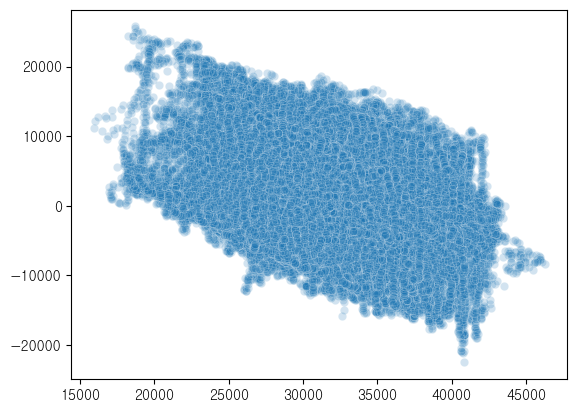

In [ ]:
resid = result2.resid
yhat = result2.predict(X)

sns.scatterplot(yhat,resid,alpha=0.2)

In [ ]:
summary(X)

Data shape: (52416, 5)
___________________________
Data Types:
float64    5
Name: Types, dtype: int64
___________________________


Types  Counts  Uniques  Nulls     Min       Max
Humidity               float64   52416     4443      0  11.340    94.800
Temperature            float64   52416     3437      0   3.247    40.010
Wind Speed             float64   52416      548      0   0.050     6.483
diffuse flows          float64   52416    10449      0   0.011   936.000
general diffuse flows  float64   52416    10504      0   0.004  1163.000

(array([  421.,  4961.,  8523.,  9505., 11125.,  8136.,  5642.,  2322.,
         1614.,   167.]),
 array([ 8560.081466 , 11444.9593954, 14329.8373248, 17214.7152542,
        20099.5931836, 22984.471113 , 25869.3490424, 28754.2269718,
        31639.1049012, 34523.9828306, 37408.86076  ]),
 <BarContainer object of 10 artists>)

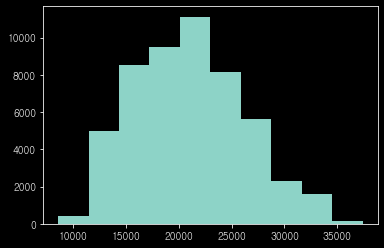

In [ ]:
import scipy.stats as stats

# 피어슨 상관계수 검정
corr = stats.pearsonr(raw_data.iloc[:,-2],raw_data.iloc[:,-1])
corr

(0.5709322667566566, 0.0)

In [ ]:
corr = stats.pearsonr(raw_data.iloc[:,-3],raw_data.iloc[:,-2])
corr

(0.8345189396462863, 0.0)